In [1]:
import pandas as pd
import numpy as np

In [2]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [224]:
robberies = pd.read_csv("../Series/monthly-boston-armed-robberies-j.csv")

# Необходимые функции

## Коррелограмма

In [225]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

## Тест Дики-Фуллера 

In [226]:
################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Как выглядят данные?

In [394]:
robberies.head(5)

,Month,Count
0,1966-01,3.713572
1,1966-02,3.663562
2,1966-03,3.912023
3,1966-04,3.688879
4,1966-05,3.761200


In [228]:
robberies.shape

(118, 2)

# Monthly Boston armed robberies

## ARIMA

In [233]:
from scipy.stats import boxcox

In [234]:
robberies['Count'] = boxcox(robberies['Count'], 0)

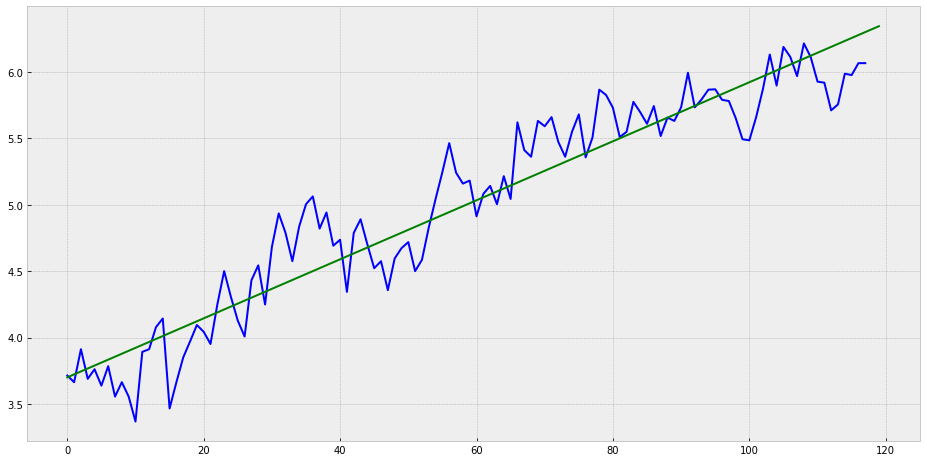

In [237]:
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(robberies.Count, color='blue')
        # выделим тренд, добавив линию, параметры подобранны.
        plt.plot([x/45 + 3.7 for x in range(120)], color='green')

In [238]:
test_stationarity(robberies.Count)

Results of Dickey-Fuller Test:
Test Statistic                  -2.013161
p-value                          0.280833
#Lags Used                      10.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


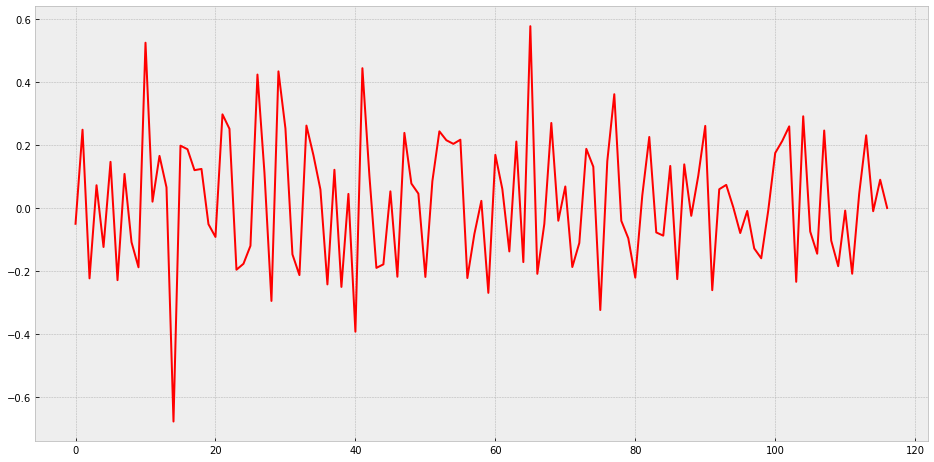

In [239]:
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        plt.plot(np.diff(robberies.Count), color='red')

In [240]:
test_stationarity(np.diff(robberies.Count))

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


In [241]:
data = np.diff(robberies.Count)

<Figure size 1152x576 with 0 Axes>

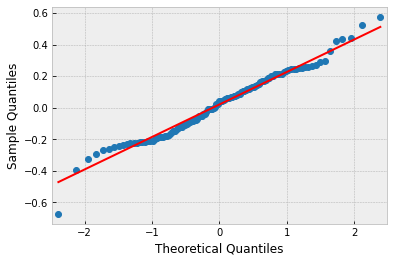

In [242]:
with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        sm.qqplot(data, line='s')

In [243]:
from statsmodels.tsa.ar_model import ar_select_order

In [244]:
sel = ar_select_order(data, 13, trend='ct')

In [245]:
sel.ar_lags

[1, 2]

In [246]:
sel_res = sel.model.fit()

In [247]:
print(sel_res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  117
Model:                     AutoReg(2)   Log Likelihood                  24.198
Method:               Conditional MLE   S.D. of innovations              0.196
Date:                Tue, 09 Aug 2022   AIC                            -38.395
Time:                        23:20:32   BIC                            -24.671
Sample:                             2   HQIC                           -32.825
                                  117                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0359      0.038      0.944      0.345      -0.039       0.110
trend         -0.0001      0.001     -0.208      0.836      -0.001       0.001
y.L1          -0.2782      0.090     -3.078      0.0

<Figure size 1152x648 with 0 Axes>

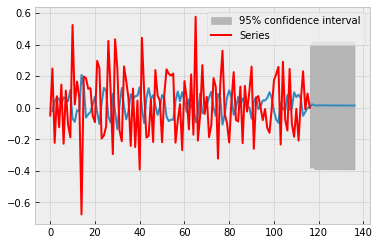

In [248]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16,9))
    sel_res.plot_predict(1, len(data)+20)
    plt.plot(data, color='red', label='Series')
    plt.legend()
    plt.show()

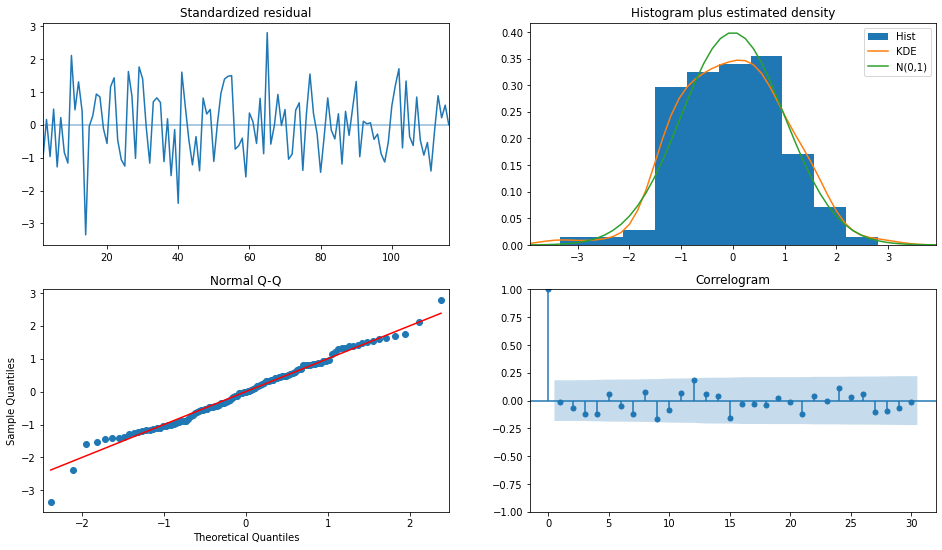

In [249]:
fig = plt.figure(figsize=(16, 9))
fig = sel_res.plot_diagnostics(fig=fig, lags=30)

In [ ]:
mod = sm.tsa.statespace.SARIMAX(robberies.Count, order=(0,1,3), seasonal_order=(1,1,1,12), trend='ct')

In [384]:
res = mod.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.88223D-02    |proj g|=  6.31549D+01


 This problem is unconstrained.



At iterate    5    f= -1.03602D-01    |proj g|=  1.27036D+01

At iterate   10    f= -1.28735D-01    |proj g|=  1.28896D+02

At iterate   15    f= -1.44635D-01    |proj g|=  4.36835D+00

At iterate   20    f= -1.47008D-01    |proj g|=  2.58864D+01

At iterate   25    f= -1.61347D-01    |proj g|=  1.81809D-01

At iterate   30    f= -1.61836D-01    |proj g|=  5.72003D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     30     55      1     0     0   5.720D-02  -1.618D-01
  F = -0.16183623852269863     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [385]:
print(res.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Count   No. Observations:                  118
Model:             SARIMAX(0, 1, 3)x(1, 1, [1], 12)   Log Likelihood                  19.097
Date:                              Wed, 10 Aug 2022   AIC                            -22.193
Time:                                      00:00:05   BIC                             -0.962
Sample:                                           0   HQIC                           -13.590
                                              - 118                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0120      0.016      0.731      0.465      -0.020       0.044
drift         -0.00

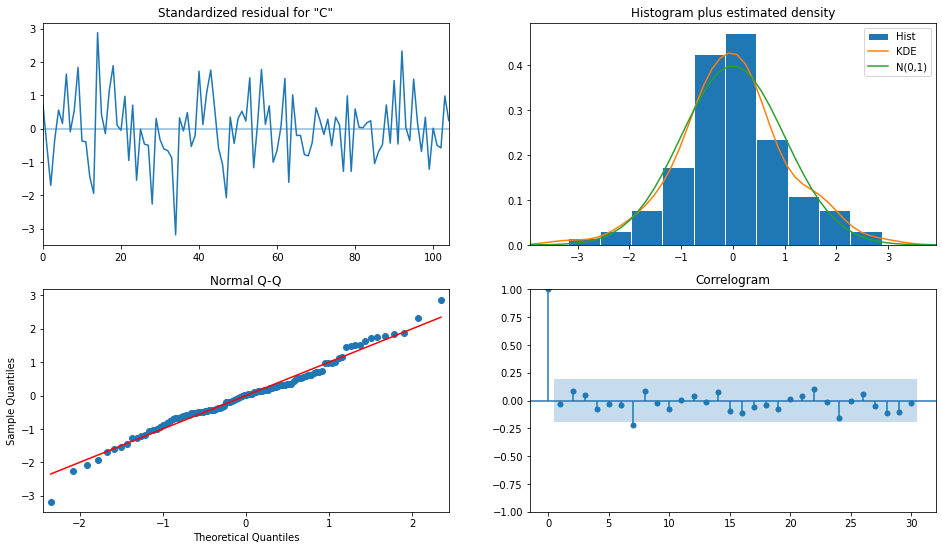

In [386]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

In [387]:
res.predict()

0      0.009444
1      3.723016
2      3.672788
3      3.921032
4      3.697671
         ...   
113    5.752613
114    6.082185
115    6.087469
116    5.877263
117    6.019551
Name: predicted_mean, Length: 118, dtype: float64

In [388]:
start = len(robberies)
end = start + 20

In [389]:
# forecast = res.predict(start=start, end=end)
forecast = res.get_prediction(dynamic=100)

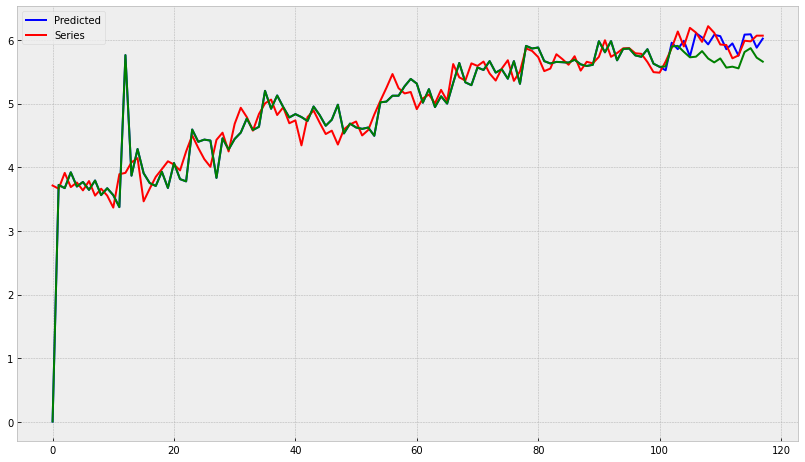

In [390]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    # res.plot_predict(1, len(robberies)+20, ax=ax)
    plt.plot(res.predict(), color='blue', label='Predicted')
    plt.plot(robberies.Count, color='red', label='Series')
    plt.plot(forecast.predicted_mean, color='green')
    plt.legend()
    plt.show()

In [392]:
from statsmodels.tools.eval_measures import rmse
error = rmse(robberies.Count, res.predict())
print(f'ARIMA(1,1,0) RMSE Error: {error}')

ARIMA(1,1,0) RMSE Error: 0.432549700096822


## Classic ML.

In [52]:
X_train = np.array([i+1 for i in range(-1, 93)], ndmin=2).reshape(94,1)
y_train = np.array(robberies_in_boston['Count'][0:94])
X_train.shape, y_train.shape

((94, 1), (94,))

In [53]:
X_test = np.array([i+1 for i in range(94, 118)], ndmin=2).reshape(24,1)
y_test = np.array(robberies_in_boston['Count'][94:])
X_test.shape, y_test.shape

((24, 1), (24,))

In [55]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [56]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [65]:
tree = AdaBoostRegressor(DecisionTreeRegressor(max_depth=3), n_estimators=100, random_state=73)

In [66]:
tree.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3),
                  n_estimators=100, random_state=73)

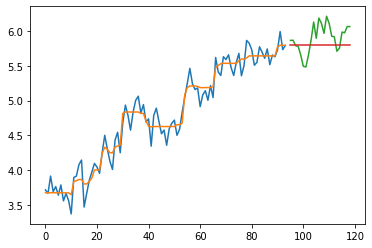

In [67]:
plt.plot(X_train, y_train)
plt.plot(X_train, tree.predict(X_train))
plt.plot(X_test, y_test)
plt.plot(X_test, tree.predict(X_test))

In [77]:
# from sklearn import svm
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [111]:
# regr = SVR(kernel='linear')
# regr = make_pipeline(Normalizer(), SVR(C=1.0, epsilon=0.2))
regr = make_pipeline(SVR(kernel='linear', C=1.0, epsilon=0.2))

In [112]:
regr.fit(X_train, y_train)

Pipeline(steps=[('svr', SVR(epsilon=0.2, kernel='linear'))])

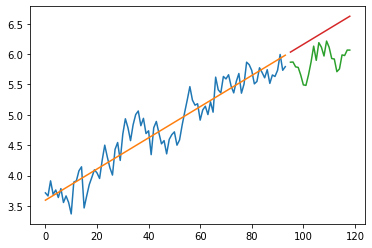

In [113]:
plt.plot(X_train, y_train)
plt.plot(X_train, regr.predict(X_train))
plt.plot(X_test, y_test)
plt.plot(X_test, regr.predict(X_test))

In [114]:
# Оценка моделей.
from sklearn.metrics import mean_squared_error
tree_rmse = mean_squared_error(y_test, tree.predict(X_test))
regr_rmse = mean_squared_error(y_test, regr.predict(X_test))
print(f'DecisionTreeRegressor RMSE: {tree_rmse}\nSVR RMSE: {regr_rmse}')

DecisionTreeRegressor RMSE: 0.04914545145514012
SVR RMSE: 0.22621702577604882
